# TO RUN NOTEBOOK:


1. Set up virtual environment.

`CONDA INSTALL`

2. Update the `respository_path` variable as the filepath to the 'TILSEG_PROJECT2024' Cloned Github Folder. 
This path is needed to access the example files used in the notebook.

In [31]:
repository_path = '/Users/laurenfrank/TILseg_Project2024'

3. Run the `Initalization Block`. This is necessary as Python adds a directory for this notebook to the list of locations where modules can be searched from when importing.

In [27]:
import sys
sys.path.append(repository_path)

4. Import the needed modules in the `Import Block`

In [28]:
# External library imports
import matplotlib.pyplot as plt
import numpy as np

## 1) Pre-Preprocessing Step on Slide Image

In [29]:
from tilseg.preprocessing import preprocess
path = repository_path + '/Example/comparison'
superpatch = preprocess(path, patches=6, training=True, save_im=True)

/Users/laurenfrank/TILseg_Project2024/Example/comparison/TCGA-A2-A0CW-01Z-00-DX1.svs


KeyboardInterrupt: 

## 2) Single Image (Testing Model Accuracy)

### - Running Segment_TILS on Single Patch - KMeans Only

#### Preview Patch
    position_7_8tissues.tif

In [33]:
image = Image.open('comparison/TCGA-A2-A0CW-01Z-00-DX1/position_7_8tissue.tif')
display(image)

FileNotFoundError: [Errno 2] No such file or directory: 'comparison/TCGA-A2-A0CW-01Z-00-DX1/position_7_8tissue.tif'

#### Run segment_TILS
    Applies a clustering model to patches and generates multiple files: TILs
    overlayed on the original H&E patch, binary segmentation masks of each
    cluster, individual clusters overlayed on the original patch, image of all
    the clusters, and a CSV file containing countour information of each TIL
    segmented from the patch. These images are saved locally inside a "ClusteringResults" 
    folder for each image.

In [32]:
from tilseg.seg import segment_TILs
from tilseg.model_selection import opt_kmeans
from tilseg.refine_kmeans import KMeans_superpatch_fit

#Opens Superpatch Image / Retrieves Pixel Data
superpatch_path = 'comparison/superpatch_training.tif'
img = Image.open(superpatch_path)
numpy_img = np.array(img)
numpy_img_reshape = np.float32(numpy_img.reshape((-1, 3))/255.)

hyperparameter_dict = opt_kmeans(numpy_img_reshape,n_clusters = [1,2,3,4,6,7,8])
kmeans_fit = KMeans_superpatch_fit(superpatch_path,hyperparameter_dict)

TIL_count_dict, kmean_labels_dict, cluster_mask_dict = segment_TILs(in_dir_path = repository_path + '/Example/comparison/TCGA-A2-A0CW-01Z-00-DX1/position_7_8tissue.tif',
                                                        out_dir_path = repository_path + '/Example/comparison',
                                                        hyperparameter_dict = None,
                                                        algorithm = 'KMeans',
                                                        model = kmeans_fit,
                                                        save_TILs_overlay = True,
                                                        save_cluster_masks = True,
                                                        save_cluster_overlays = True,
                                                        save_all_clusters_img = True,
                                                        save_csv = True,
                                                        multiple_images = False)

In [ ]:
#Contour
from PIL import Image
import matplotlib.pyplot as plt

# Open the images
image1 = Image.open('comparison/TCGA-A2-A0CW-01Z-00-DX1/position_7_8tissue.tif')
image2 = Image.open('path_to_second_image')
image3 = Image.open('path_to_third_image')

# Create a figure and axis objects
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Display the images on separate axes
axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title('Image 1')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('Image 2')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Image 3')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the images
plt.show()

### Running Kmeans-Dbscan Model on Same Patch - Kmeans fed into Dbscan

## 3) Multiple Images (Predicting Superpatch Model on Superpatches)

### Running Segment_TILS on Folder of Patches from Slide - KMeans Only

### Running Kmeans-Dbscan Model on Superpatch and Folder of Patches - KMeans fed into Dbscan

Found hyperparameters. Time took: 3.3429034471511843 minutes.
Completed Kmeans fitting. Time took: 0.6558260003725688 minutes.


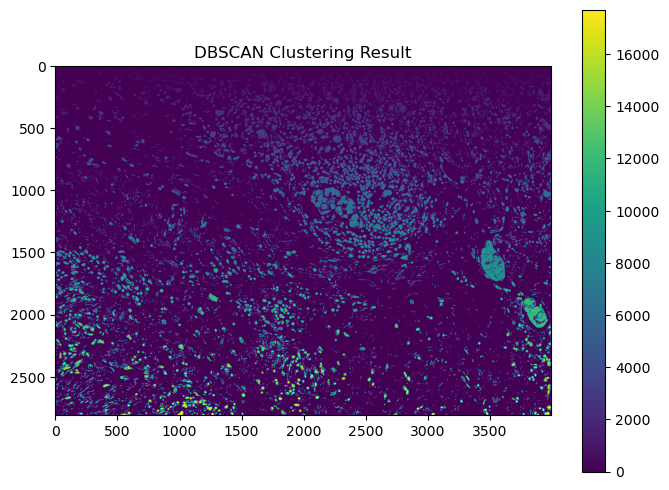

Script completed. Dbscan fitting time: 14.879393100738525 seconds.


In [ ]:
from tilseg.seg import kmean_to_spatial_model_superpatch_wrapper
im_labels, dbscan_model, cluster_mask_dict = kmean_to_spatial_model_superpatch_wrapper(superpatch_path = '/Users/laurenfrank/TILseg_Project2024/Example/comparison/superpatch_training.tif',
                                            in_dir_path = '/Users/laurenfrank/TILseg_Project2024/Example/comparison/TCGA-A2-A0CW-01Z-00-DX1',
                                            spatial_hyperparameters= {'eps': 3,'min_samples': 1},
                                            n_clusters = [1,2,4,5,6,7,8,9],
                                            out_dir_path = '/Users/laurenfrank/TILseg_Project2024/Example',
                                            save_TILs_overlay = True,
                                            save_cluster_masks = True,
                                            save_cluster_overlays =  True,
                                            save_all_clusters_img = True,
                                            save_csv = True)

### BREAK